# Qucik Start: Use Cases and Examples with Synthetic Data
---
This notebook provides an example of conducting an offline evaluation of the performance of two counterfactual policies using OPE estimators and synthetic logged bandit feedback.

Our example with synthetic data contains the follwoing four major steps:
- (1) Synthetic Data Generation
- (2) Offline Bandit Simulation
- (3) Off-Policy Evaluation
- (4) Evaluation of OPE Estimators

Please see [../synthetic/](https://github.com/st-tech/zr-obp/blob/master/examples/synthetic/) for a more sophisticated example of the evaluation of OPE.

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RandomForest
# import open bandit pipeline (obp)
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_behavior_policy
)
from obp.policy import EpsilonGreedy, LinEpsilonGreedy, LogisticEpsilonGreedy
from obp.simulator import run_bandit_simulation
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting,
    DirectMethod,
    DoublyRobust
)

## (1) Synthetic Data Generation
We prepare easy-to-use synthetic data generator: SyntheticBanditDataset class in dataset module.
It takes number of actions (n_actions), dimension of context vectors (dim_context, dim_action_context), reward function (reward_function), and behavior policy (behavior_policy_function) as inputs and generates synthetic bandit dataset with a given number of rounds.

In [2]:
# generate synthetic bandit dataset with 10 actions
# one can define their own `reward_function` and `behavior_policy_function` such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=10,
    dim_context=5,
    dim_action_context=5,
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345
)
# obtain logged bandit feedback with 1 million rounds generated by linear contextual behavior polciy
n_rounds = 1000000
bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)

bandit_feedback # `bandit_feedback` is a dictionary storing synthetic logged bandit feedback

{'n_rounds': 1000000,
 'n_actions': 10,
 'context': array([[ 0.06987669,  0.24667411, -0.0118616 ,  1.00481159,  1.32719461],
        [-0.91926156, -1.54910644,  0.0221846 ,  0.75836315, -0.66052433],
        [ 0.86258008, -0.0100319 ,  0.05000936,  0.67021559,  0.85296503],
        ...,
        [ 0.79386663, -1.77140949,  2.4596316 ,  0.59552202, -0.58439503],
        [-0.86420741,  0.49423285, -0.929633  , -0.79552381, -1.50996934],
        [-0.19474421, -0.91629866,  0.88907386, -0.66633859,  0.25754172]]),
 'action': array([0, 1, 9, ..., 2, 9, 0]),
 'position': array([0, 0, 0, ..., 0, 0, 0]),
 'reward': array([1, 0, 1, ..., 0, 0, 0]),
 'expected_reward': array([[0.79484127, 0.98710467, 0.91364645, ..., 0.80883287, 0.0262742 ,
         0.86335842],
        [0.21316852, 0.63537277, 0.32594524, ..., 0.13998069, 0.00316771,
         0.55818704],
        [0.84340111, 0.98274578, 0.92609427, ..., 0.74362081, 0.03999977,
         0.83685006],
        ...,
        [0.6625081 , 0.94690187, 

## (2) Offline Bandit Simulation¶
After preparing a dataset, we now run offline bandit simulation on the logged bandit feedback.
We use Bernoulli Thompson Sampling impelemted in policy module as a first counterfacutal policy and Logistic Epsilon Greedy as a second counterfactual policy. <br>
run_bandit_simulation in simulation module takes a counterfactual policy and a training dataset as inputs and run the policy on the dataset.

In [3]:
# define the context-free epsilong greedy (EpsilonGreedy) policy as a first counterfactual policy
counterfactual_policy_a = EpsilonGreedy(
    n_actions=dataset.n_actions, 
    len_list=dataset.len_list,
    epsilon=0.01,
    random_state=12345,
)
# run EpsilonGreedy on the synthetic bandit feedback
selected_actions_a = run_bandit_simulation(bandit_feedback=bandit_feedback, policy=counterfactual_policy_a)
# selected_actions is an array of shape (n_rounds, len_list)
# containing selected actions by counterfactual policy in an simulation
selected_actions_a

100%|██████████| 1000000/1000000 [00:09<00:00, 102709.46it/s]


array([[8],
       [5],
       [4],
       ...,
       [7],
       [7],
       [7]])

In [4]:
# define the Logistic Epsilon Greedy (Logistic EpsilonGreedy) policy as a second counterfactual policy
counterfactual_policy_b = LogisticEpsilonGreedy(
    n_actions=dataset.n_actions, 
    len_list=dataset.len_list,
    dim=dataset.dim_context,
    epsilon=0.01,
    random_state=12345,
)
# run Logistic EGreedy on the synthetic bandit feedback
selected_actions_b = run_bandit_simulation(bandit_feedback=bandit_feedback, policy=counterfactual_policy_b)
# selected_actions is an array of shape (n_rounds, len_list)
# containing selected actions by counterfactual policy in an simulation
selected_actions_b

100%|██████████| 1000000/1000000 [01:44<00:00, 9532.48it/s]


array([[9],
       [9],
       [9],
       ...,
       [1],
       [1],
       [1]])

In [5]:
# define the Linear Epsilon Greedy (Linear EpsilonGreedy) policy as a third counterfactual policy
counterfactual_policy_c = LinEpsilonGreedy(
    n_actions=dataset.n_actions, 
    len_list=dataset.len_list,
    dim=dataset.dim_context,
    epsilon=0.01,
    random_state=12345,
)
# run Linear Epsilon Greedy on the synthetic bandit feedback
selected_actions_c = run_bandit_simulation(bandit_feedback=bandit_feedback, policy=counterfactual_policy_c)
# selected_actions is an array of shape (n_rounds, len_list)
# containing selected actions by counterfactual policy in an simulation
selected_actions_c

100%|██████████| 1000000/1000000 [01:30<00:00, 11017.97it/s]


array([[9],
       [9],
       [9],
       ...,
       [1],
       [2],
       [3]])

## (3) Off-Policy Evaluation (OPE)
Off-policy evaluation attempts to estimate the performance of bandit algorithms using log data generated by offline bandit simulation. Here, we use the *InverseProbabilityWeighting*, *DirectMethod*, and *Doubly Robust* estimators as OPE estimators and estiamte the performance of the two counterfacutal policies using the simulation log data. Finally, we summarize and visualize the results of OPE.

In [6]:
# estimate the policy value of the three counterfactual policies 
# based on selected actions in offline bandit simulation
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
# `RegressionModel` predicts the expected reward and is used in Direct Method and Doubly Robust estimators.
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,  
    regression_model=RegressionModel(base_model=RandomForest(n_estimators=10)),
    action_context=dataset.action_context,
    ope_estimators=[
        InverseProbabilityWeighting(),
        DirectMethod(), 
        DoublyRobust()
    ]
)

mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.560654          0.550384          0.570465
dm   0.570610          0.570020          0.571191
dr   0.571182          0.568246          0.574246 



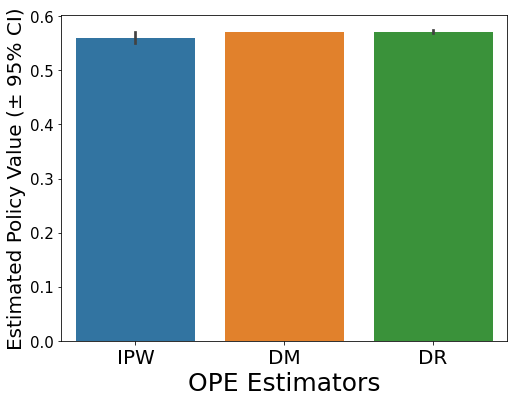

In [7]:
# estimated confidence intervals of policy value of EpsilonGreedy by OPE estimators
estimated_policy_value_a, estimated_interval_a = ope.summarize_off_policy_estimates(
    selected_actions=selected_actions_a
)
print(estimated_interval_a, '\n')
# visualize estimated policy values of EpsilonGreedy by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(selected_actions=selected_actions_a)

mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.743006          0.737655          0.748145
dm   0.735633          0.735130          0.736078
dr   0.738274          0.737046          0.739291 



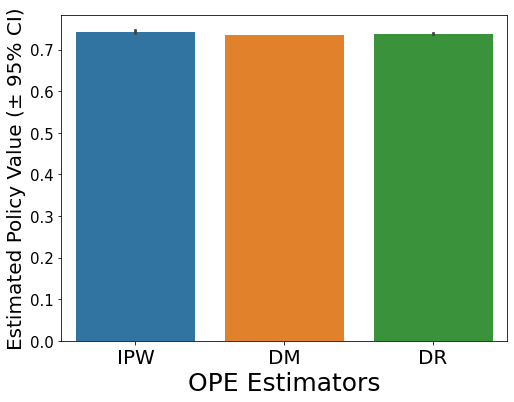

In [8]:
# estimated confidence intervals of policy value of Logistic EpsilonGreedy by OPE estimators
estimated_policy_value_b, estimated_interval_b = ope.summarize_off_policy_estimates(
    selected_actions=selected_actions_b
)
print(estimated_interval_b, '\n')
# visualize estimated policy values of Logistic EpsilonGreedy by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(selected_actions=selected_actions_b)

mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.743006          0.737655          0.748145
dm   0.735633          0.735130          0.736078
dr   0.738274          0.737046          0.739291 



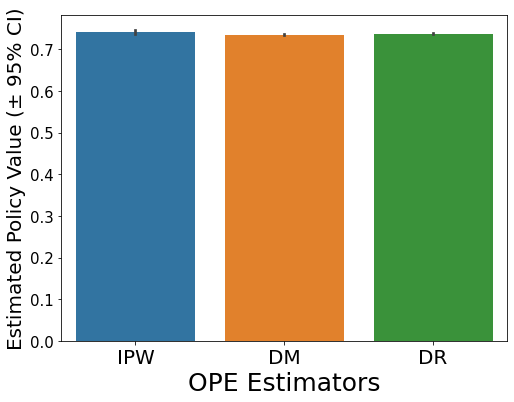

In [9]:
# estimated confidence intervals of policy value of Linear EpsilonGreedy by OPE estimators
estimated_policy_value_c, estimated_interval_c = ope.summarize_off_policy_estimates(
    selected_actions=selected_actions_c
)
print(estimated_interval_b, '\n')
# visualize estimated policy values of Linear EpsilonGreedy by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(selected_actions=selected_actions_b)

Our OPE procedure estimates that Logistic and Linear Epsilon Greedy largely outperform the context-free Epsilon Greedy.

## (4) Evaluation of OPE estimators
Our final step is the evaluation of OPE estimators, which evaluates the accuracy of the OPE estimators in use.
With the synthetic dataset, we can know the ground-truth policy value of the counterfactual policies (Bernoulli TS and Logistc Egreedy). Therefore, we can compare the estimated policy values by OPE estimators with the ground-turths to evaluate estimators.

In [10]:
# we first estimate the ground-truth policy values of the three counterfactual policies
# using the full expected reward contained in the bandit feedback dictionary
ground_truth_a = bandit_feedback['expected_reward'][np.arange(n_rounds), selected_actions_a.flatten()].mean()
ground_truth_b = bandit_feedback['expected_reward'][np.arange(n_rounds), selected_actions_b.flatten()].mean()
ground_truth_c = bandit_feedback['expected_reward'][np.arange(n_rounds), selected_actions_c.flatten()].mean()

print(f'ground-truth policy value of EpsilonGreedy: {ground_truth_a}')
print(f'ground-truth policy value of Logistic EpsilonGreedy: {ground_truth_b}')
print(f'ground-truth policy value of Linear EpsilonGreedy: {ground_truth_c}')

ground-truth policy value of EpsilonGreedy: 0.5736564488379409
ground-truth policy value of Logistic EpsilonGreedy: 0.7448966661566782
ground-truth policy value of Linear EpsilonGreedy: 0.7703969172204865


In fact, Linear EpsilonGreedy reveals the best performance among the three counterfactual policies.

Using the above ground-truths, let's evaluate the accuracy of the off-policy estimators.

In [11]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy value of EpsilonGreedy and the ground-truth.
# `evaluate_performance_of_estimators` method returns a dictionary 
# containing the relative estimation error of given OPE estimators 
relative_estimation_errors_a = ope.evaluate_performance_of_estimators(
    selected_actions=selected_actions_a,
    ground_truth_policy_value=ground_truth_a
)

# Direct Method reveals the best estimation performance (lower is better)
# when evaluating the performance of BernoulliTS
relative_estimation_errors_a

{'ipw': 0.02393811880776725,
 'dm': 0.005240503866086445,
 'dr': 0.004171636423478071}

In [12]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy value of Logistic EpsilonGreedy and the ground-truth
# `evaluate_performance_of_estimators` method returns a dictionary 
# containing the relative estimation error of given OPE estimators 
relative_estimation_errors_b = ope.evaluate_performance_of_estimators(
    selected_actions=selected_actions_b,
    ground_truth_policy_value=ground_truth_b
)

# Inverse Probability Weighting reveals the best estimation performance (lower is better)
# when evaluating the performance of Logistic EGreedy
relative_estimation_errors_b

{'ipw': 0.002637047616191471,
 'dm': 0.012441546026101907,
 'dr': 0.008862405981479898}

In [13]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy value of Linear EpsilonGreedy and the ground-truth
# `evaluate_performance_of_estimators` method returns a dictionary 
# containing the relative estimation error of given OPE estimators 
relative_estimation_errors_c = ope.evaluate_performance_of_estimators(
    selected_actions=selected_actions_c,
    ground_truth_policy_value=ground_truth_c
)

# Inverse Probability Weighting reveals the best estimation performance (lower is better)
# when evaluating the performance of Logistic EGreedy
relative_estimation_errors_c

{'ipw': 0.004476741268652312,
 'dm': 0.014141174473792002,
 'dr': 0.010766107255114751}

Please see [../synthetic/](https://github.com/st-tech/zr-obp/blob/master/examples/synthetic/) for a more sophisticated example of the evaluation of OPE.